In [1]:
# Introduction

In [2]:
## We need to first import the necessary packages and files

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [4]:
heart_disease_training= pd.read_csv("C:/Users/Calvi/Documents/Data Science Toolbox/Assessment 1/data/TrainingDataImputation.csv")
heart_disease_test = pd.read_csv("https://raw.githubusercontent.com/erinp0/DST-Assessment-1/main/Erin%20Pollard/test_imputed.csv")

In [5]:
## We then separate the features and target variables

In [6]:
y_train = np.array(heart_disease_training.iloc[:, 0]).astype(int)[np.newaxis,:].T
y_test = np.array(heart_disease_test.iloc[:, 0]).astype(int)[np.newaxis,:].T
del heart_disease_training['HeartDiseaseorAttack']
del heart_disease_test['HeartDiseaseorAttack']

In [7]:
x_train = heart_disease_training.to_numpy()
x_test = heart_disease_test.to_numpy()

In [8]:
def center_function(data):
    mean = data.mean(axis=1)
    std = data.std(axis=1)
    for i in range(data.shape[1]):
        data[i] -= mean[i]
        data[i] /= std[i]
    return data,mean,std

In [9]:
cf = center_function(x_train)
x_train_centered = cf[0]

In [10]:
print("Standardised Training Data:")
print(pd.DataFrame(x_train_centered).head())

         0         1         2         3         4         5         6   \
0  1.392049  0.099506  1.392049 -0.495064  0.099506  0.099506 -0.331341   
1  0.827005  0.827005  0.827005 -1.354394  0.827005 -0.731137 -1.250518   
2  1.013108  1.013108  1.013108 -1.047109  1.013108 -0.398000 -0.868369   
3 -0.099784  1.527512 -1.727079 -0.718156  1.527512 -0.099784 -0.642215   
4  0.693649  0.693649  0.693649 -1.398234  0.693649  0.693649 -1.243280   

         7         8         9   ...        11        12        13        14  \
0 -1.193037 -1.193037 -1.193037  ...  1.392049  0.099506  0.530354 -1.109647   
1 -0.731137  0.827005  0.827005  ...  0.827005 -0.731137  0.827005  0.827005   
2 -0.398000  1.013108  1.013108  ...  1.013108 -1.809108  0.072370 -1.718068   
3 -0.099784 -0.099784 -0.099784  ...  1.527512 -0.099784  0.442648 -1.622092   
4  0.693649  0.693649  0.693649  ...  0.693649  0.693649  0.693649 -2.211744   

         15        16        17        18        19        20  
0 -1

In [11]:
# PCA

In [13]:
percentage = 99 # This is the amount of explained variance we desire

In [14]:
def cov_eigen(data):
    hd_scaled = StandardScaler().fit_transform(data)
    features = hd_scaled.T
    cov_matrix = np.cov(features)
    values, vectors = np.linalg.eig(cov_matrix)
    idx = values.argsort()[::-1]
    vectors = vectors.T[:,idx]
    return values,vectors

In [15]:
def pcafeatures(data,percentage):
    hd_scaled = StandardScaler().fit_transform(data)
    features = hd_scaled.T
    cov_matrix = np.cov(features)
    values, vectors = np.linalg.eig(cov_matrix)
    explained_variances = []
    a = 0
    num = 0
    for i in range(len(values)):
        explained_variances.append(values[i] / np.sum(values))
    for i in range(len(explained_variances)):
        while a < percentage:
            a += explained_variances[i]*100
            num += 1
    pc_feat = ['PC{}'.format(i+1) for i in range(num)]
    return pc_feat,num,explained_variances

In [16]:
num_of_comps = pcafeatures(x_train_centered,percentage)[1]
cov_evecs = cov_eigen(x_train_centered)[1].T[:,:num_of_comps]

In [17]:
print("Covariance Eigenvectors:")
print(pd.DataFrame(cov_evecs).head())

eigenvectors:
          0         1         2         3         4         5         6  \
0  0.230155  0.240133  0.195575 -0.080941 -0.198336 -0.087512 -0.008209   
1  0.299364  0.117451  0.399363  0.003162  0.096286 -0.297587 -0.140347   
2  0.255722  0.015781  0.404610  0.024523  0.185616 -0.315462 -0.169093   
3  0.233122  0.016640 -0.080045 -0.472549  0.025567 -0.044482  0.072294   
4  0.274376  0.025990 -0.206620 -0.199250 -0.261685  0.074214 -0.085270   

          7  
0  0.058814  
1 -0.035278  
2 -0.059154  
3 -0.028236  
4 -0.215008  


In [18]:
x_train_pca = np.dot(x_train_centered,cov_evecs)

In [19]:
print(pd.DataFrame(x_train_pca[:5,:]))

          0         1         2         3         4         5         6  \
0 -0.988286  1.343361  1.491332 -1.409695  0.309475 -0.821137 -0.799575   
1 -0.118285 -1.111554  1.105812 -0.095905  1.381766 -0.251756 -1.524183   
2  0.292101 -0.161933 -0.249739 -0.174526 -1.063880 -1.776465 -1.626994   
3 -0.242681  0.696821 -0.886288 -1.152619 -1.628788 -0.880672 -1.131532   
4  0.426728 -0.152492  0.707130  0.463696 -1.620082 -0.722687 -1.692047   

          7  
0 -0.033532  
1 -0.242042  
2 -0.276475  
3 -0.125887  
4  0.587075  


In [23]:
# Logistic Regression

In [24]:
#%% Parameter initialize and sigmoid function

def initialize_weights_and_bias(dimension):
    
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w,b

def sigmoid(z):
    
    y_head = 1 / (1+np.exp(-z))
    
    return y_head

In [25]:
#%% Loss function

def logloss(y_hat,y):
    a = np.log(y_hat)
    b = np.log(1-y_hat)
    loss = (-1/x_train.shape[0]) * np.sum(y*a + (1-y)*b)
    return loss

In [26]:
#%% Forward and Backward Propagation

def forward_backward_propagation(w,b,x_train,y_hat):
    
    z = np.dot(x_train,w) + b
    y_hat = sigmoid(z)
    cost = logloss(y_hat,y_train)
    
    #backward propogation
    derivative_weight = np.dot((y_hat-y_train).T,x_train)/x_train.shape[0]
    derivative_bias = np.sum(y_hat-y_train)/x_train.shape[0]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

In [27]:
#%% Updating (Learning) Parameters
    
def update(w, b, x_train, y_train, learning_rate,number_of_iteration):
    cost_list = []
    cost_list2 = []
    index = []
    # updating(learning) parameters is number_of_iteration times
    for i in range(number_of_iteration):
        # make forward and backward propagation and find cost and gradients
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        # lets update
        w = w - learning_rate * (gradients["derivative_weight"].T)
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 10 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost)) #if section defined to print our cost values in every 10 iteration. We do not need to do that. It's optional.
     # we update(learn) parameters weights and bias
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iteration")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list 

In [28]:
#%% Prediction

def predict(w,b,x_test):
    # x_test is a input for forward propagation
    z = sigmoid(np.dot(x_test,w)+b)
    Y_prediction = np.zeros((x_test.shape[0],1))
    # if z is bigger than 0.5, our prediction is one means has diabete (y_head=1),
    # if z is smaller than 0.5, our prediction is zero means does not have diabete (y_head=0),
    for i in range(len(z)):
        if z[i]< 0.5:
            Y_prediction[i] = 0
        else:
            Y_prediction[i] = 1

    return Y_prediction

#predict(parameters["weight"],parameters["bias"],x_test)

In [29]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    # initialise
    dimension =  x_train.shape[1]
    w,b = initialize_weights_and_bias(dimension)
    
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    

    # Print train/test Errors
    
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))

In [30]:
## We need to prepare our test dataset before predicting the outcome. We need to project the test data into the same space as the training. So we follow the standardising method but use the mean and standard deviation from the training data

In [31]:
for i in range(x_test.shape[1]):
    x_test[:,i] -= cf[1][i]     
    x_test[:,i] /= cf[2][i]

In [32]:
x_test_pca = np.dot(x_test,cov_evecs)

Cost after iteration 0: 0.747076
Cost after iteration 10: 0.286301
Cost after iteration 20: 0.272464
Cost after iteration 30: 0.265954
Cost after iteration 40: 0.260995
Cost after iteration 50: 0.257415
Cost after iteration 60: 0.254643
Cost after iteration 70: 0.252426
Cost after iteration 80: 0.250601
Cost after iteration 90: 0.249062
Cost after iteration 100: 0.247740
Cost after iteration 110: 0.246586
Cost after iteration 120: 0.245567
Cost after iteration 130: 0.244656
Cost after iteration 140: 0.243834
Cost after iteration 150: 0.243088
Cost after iteration 160: 0.242406
Cost after iteration 170: 0.241779
Cost after iteration 180: 0.241199
Cost after iteration 190: 0.240661


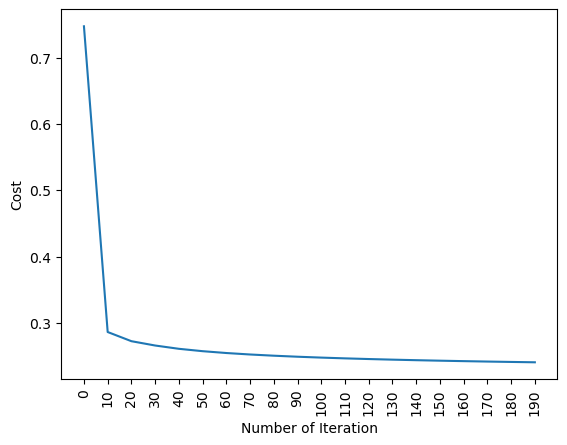

test accuracy: 68.33005893909626 %


In [39]:
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 4, num_iterations = 200)